# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [98]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [112]:
azdias=pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
feat_info=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)
f_row,f_col=azdias.shape

(891221, 85)
(85, 4)


In [5]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
azdias.isnull().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [314]:
#column_names=azdias.columns
#column_names
#nnrow=10
#for col_name in column_names:
    
    
#    for nrow in range(nnrow):
#        missing_value=feat_info['missing_or_unknown'][nrow]
#        missing_value=missing_value.strip('[')
#        missing_value=missing_value.strip(']')
#        missing_value=missing_value.split(',')
#        for value in missing_value:
#                azdias_value=azdias[col_name][nrow]
#                if(value!='' and value!='XX' and value!='X' and azdias_value!=''):
#                     azdias[col_name]=azdias[col_name].replace (to_replace = value, value = np.NaN, regex = True, inplace = True)
                     
                      


In [315]:
#values=[]
#for nrow in range(f_row):
#    missing_value=feat_info['missing_or_unknown'][nrow]
#    missing_value=missing_value.strip('[')
#    missing_value=missing_value.strip(']')
#    missing_value=missing_value.split(',')
#    values.append(missing_value)
    
#for i in range(len(values)):
    #for j in range(len(values[i])):
    #    if (values[i][j] != '' and values[i][j] != 'X' and values[i][j] != 'XX'):
   #         values[i][j] = float(values[i][j]) 
            
#for k in range(len(values)): 
#    column_name = feat_info.iloc[k]['attribute']
#   # azdias[column_name] = azdias[column_name].astype(float)
#    azdias[column_name]=azdias[column_name].replace (to_replace =values[k],value = np.NaN,regex = True,inplace = True)
    

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for col in range(f_col):
    column_name=azdias.columns[col]
    missing=feat_info.iloc[col,3]
    missing=missing.strip('[')
    missing=missing.strip(']')
    missing=missing.split(',')
    if(missing!=['']):
        
        
        for obj in missing:
            if azdias[column_name].dtype =='object': 
                
                azdias.loc[azdias[column_name]==obj,column_name]=np.NaN
                
                
            else:   
                obj=int(obj)
                
                azdias.loc[azdias[column_name]==obj,column_name]=np.NaN


In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_data_count=azdias.isnull().sum()
null_data_count

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

(array([39., 40.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([     0. ,  88906.1, 177812.2, 266718.3, 355624.4, 444530.5,
        533436.6, 622342.7, 711248.8, 800154.9, 889061. ]),
 <a list of 10 Patch objects>)

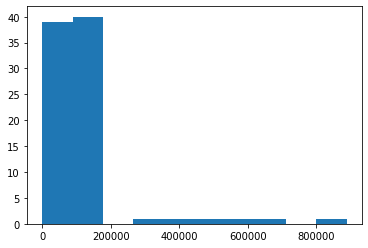

In [15]:
# Investigate patterns in the amount of missing data in each column.
data=pd.DataFrame(null_data_count)
data.columns=['nan']
plt.hist(data['nan'])



In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliners=data[data['nan']>200000]
azdias=azdias.drop(outliners.index, axis=1)


In [23]:
#Updating feat_info according to Azdias new columns
ft_new=list(azdias.columns)
feat_updated = feat_info[feat_info['attribute'].isin(ft_new)]


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [18]:
#Outliners
print(outliners)

                 nan
AGER_TYP      685843
GEBURTSJAHR   392318
TITEL_KZ      889061
ALTER_HH      310267
KK_KUNDENTYP  584612
KBA05_BAUMAX  476524


In [24]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I have removed the columns with NaNs more than 200000 as according to the hist() mostly columns have NaNs less than 200000.

Thus the outliners according to me are: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX with NaNs >200000.   

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([6.97109e+05, 7.76340e+04, 1.28010e+04, 9.53300e+03, 8.29000e+02,
        1.55000e+02, 1.40160e+04, 5.03100e+03, 2.80380e+04, 4.60750e+04]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

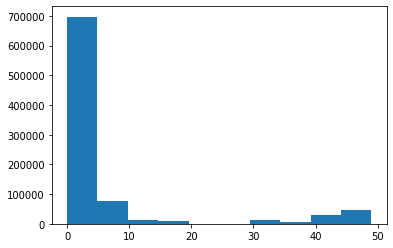

In [25]:
# How much data is missing in each row of the dataset?
null_data_row=azdias.isnull().sum(axis=1)
null_row=pd.DataFrame(null_data_row)
null_row.columns=['nan']
plt.hist(null_row['nan'])


In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_1=null_row[null_row['nan']>=20]
row_2=null_row[null_row['nan']<20]

azdias1=azdias.iloc[row_1.index,:]

azdias2=azdias.iloc[row_2.index,:]


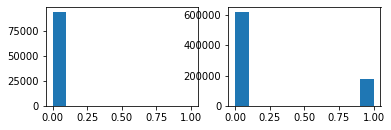

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
diag = plt.figure()
fig1 = diag.add_subplot(221)
fig1.hist(azdias1['GREEN_AVANTGARDE'])
fig2 = diag.add_subplot(222)
fig2.hist(azdias2['GREEN_AVANTGARDE'])

plt.show()


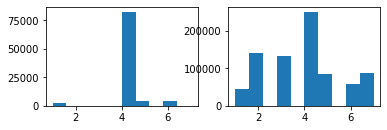

In [28]:
diag = plt.figure()
fig1 = diag.add_subplot(221)
fig1.hist(azdias1['SEMIO_RAT'])
fig2 = diag.add_subplot(222)
fig2.hist(azdias2['SEMIO_RAT'])

plt.show()

/Users/moon/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/moon/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


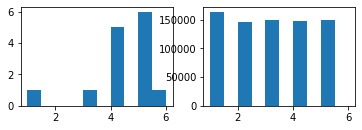

In [29]:
diag = plt.figure()
fig1 = diag.add_subplot(221)
fig1.hist(azdias1['MOBI_REGIO'])
fig2 = diag.add_subplot(222)
fig2.hist(azdias2['MOBI_REGIO'])

plt.show()

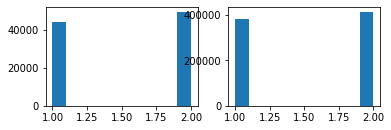

In [30]:
diag = plt.figure()
fig1 = diag.add_subplot(221)
fig1.hist(azdias1['ANREDE_KZ'])
fig2 = diag.add_subplot(222)
fig2.hist(azdias2['ANREDE_KZ'])

plt.show()

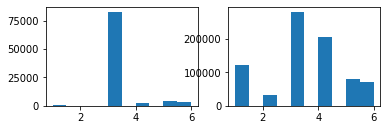

In [31]:
diag = plt.figure()
fig1 = diag.add_subplot(221)
fig1.hist(azdias1['ZABEOTYP'])
fig2 = diag.add_subplot(222)
fig2.hist(azdias2['ZABEOTYP'])

plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

After plotting the features with no NaN(missing values), we figured out that there is not very much significant change in values of subset with several missing values and the one with lesser. Thus dropping the subset with lots of missing value would be a good idea. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?

feat_updated['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
ft_cat = feat_updated[feat_updated["type"]=="categorical"]["attribute"]
azdias2[ft_cat]

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
3,2.0,2.0,6.0,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2,2A
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,2.0,5.0,1.0,12.0,0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,4.0,8.0,W,7,7A
891217,1.0,4.0,6.0,1.0,0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,NaN,6.0,8.0,W,9,9D
891218,2.0,4.0,1.0,10.0,0,NaN,NaN,4.0,2.0,1.0,2.0,0.0,1.0,4.0,8.0,W,4,4C
891219,1.0,3.0,1.0,9.0,0,9.0,5.0,2.0,1.0,1.0,0.0,0.0,2.0,5.0,8.0,W,9,9D


In [40]:
#Seems like OST_WEST_KZ have some unusual Ws lets check for more such values
azdias2.OST_WEST_KZ.unique()

array(['W', 'O'], dtype=object)

In [41]:
#OST_WEST_KZ have values W and O which will be replaced to 1 and 0 respectively
azdias_new = azdias2.replace({'OST_WEST_KZ':{'W': 1, 'O': 0}})


In [43]:
#recheck
azdias_new.OST_WEST_KZ.unique()

array([1, 0])

In [47]:
#Finding multilevel features
multi_level=[]
for att in ft_cat:
    if azdias_new[att].nunique()>2:
        multi_level.append(att)
   


In [48]:
display(multi_level)

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [49]:
#Dropping multi level features
for dropo in multi_level:
    azdias_new=azdias_new.drop(dropo, axis=1)

In [51]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

Dropped all multi level features and converted OST_WEST_KZ values(W and O) to (1 and 0) respectively.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### For Reference~ PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [59]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new['PRAEGENDE_JUGENDJAHRE_decade']=azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new['PRAEGENDE_JUGENDJAHRE_movement']=azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [60]:
#Initializing dictionary according to the given reference
decade_dic={1:1 , 2:1 , 3:2 , 4:2 , 5:3 , 6:3 , 7:3 , 8:4 , 9:4 , 10:5 , 11:5 , 12:5 , 13:5 , 14:6 , 15:6}
movement_dic={1:1 , 2:0 , 3:1 , 4:0 , 5:1 , 6:0 , 7:0 , 8:1 , 9:0 , 10:1 , 11:0 , 12:1 , 13:0 , 14:1 , 15:0}

In [61]:
#Replaing values according to dictionary
azdias_new["PRAEGENDE_JUGENDJAHRE_decade"].replace(decade_dic,inplace=True)
azdias_new["PRAEGENDE_JUGENDJAHRE_movement"].replace(movement_dic,inplace=True)

In [62]:
#Now we will drop the PRAEGENDE_JUGENDJAHRE column as it is of no use now
azdias_new.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#Similarily for CAMEO_INTL_2015
azdias_new["CAMEO_INTL_2015_WEALTH"]=azdias_new.CAMEO_INTL_2015
azdias_new["CAMEO_INTL_2015_LIFE"]=azdias_new.CAMEO_INTL_2015
azdias_new.CAMEO_INTL_2015.head()


1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [65]:
#Initializing dictionary according to the given reference
wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':4,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

In [66]:
#Replaing values according to dictionary
azdias_new["CAMEO_INTL_2015_WEALTH"].replace(wealth_dic,inplace=True)
azdias_new["CAMEO_INTL_2015_LIFE"].replace(life_dic,inplace=True)

In [67]:
#Now we will drop the CAMEO_INTL_2015 column as it is of no use now
azdias_new.drop("CAMEO_INTL_2015",axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I initialized new two columns named PRAEGENDE_JUGENDJAHRE_decade and PRAEGENDE_JUGENDJAHRE_movement with default values of PRAEGENDE_JUGENDJAHRE. According to the reference I replaced the values of these two new columns by creating their dictionaries of actual values. Similarily I did for CAMEO_INTL_2015 :)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [83]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_features = feat_updated[feat_updated["type"]=="mixed"]["attribute"]
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [86]:
#Lets drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 as we already removed them from azdias_new
mixed_features.drop(22,inplace=True)
mixed_features.drop(59,inplace=True)

In [87]:
#Looks Perfect
mixed_features

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object

In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#We must remove the mixed features from the DataFrame
azdias_new.drop(mixed_features,axis=1,inplace=True)


In [90]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            794304 non-null  float64
 1   ANREDE_KZ                       797077 non-null  float64
 2   FINANZ_MINIMALIST               797077 non-null  float64
 3   FINANZ_SPARER                   797077 non-null  float64
 4   FINANZ_VORSORGER                797077 non-null  float64
 5   FINANZ_ANLEGER                  797077 non-null  float64
 6   FINANZ_UNAUFFAELLIGER           797077 non-null  float64
 7   FINANZ_HAUSBAUER                797077 non-null  float64
 8   GREEN_AVANTGARDE                797077 non-null  int64  
 9   HEALTH_TYP                      760739 non-null  float64
 10  RETOURTYP_BK_S                  792445 non-null  float64
 11  SEMIO_SOZ                       797077 non-null  float64
 12  SEMIO_FAM       

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [120]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    ff_row,ff_col=df.shape
    
    # convert missing value codes into NaNs, ...
    for fcol in range(ff_col):
        fcolumn_name=df.columns[fcol]
        fmissing=feat_info.iloc[fcol,3]
        fmissing=fmissing.strip('[')
        fmissing=fmissing.strip(']')
        fmissing=fmissing.split(',')
        if(fmissing!=['']):

            for fobj in fmissing:
                if df[fcolumn_name].dtype =='object': 

                    df.loc[df[fcolumn_name]==fobj,fcolumn_name]=np.NaN 

                else:   
                    fobj=int(fobj)

                    df.loc[df[fcolumn_name]==fobj,fcolumn_name]=np.NaN
    
   
    
    
    # remove selected columns and rows, ...
    #Removing Columns
    fremove_col=['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ']
    df.drop(fremove_col, axis=1,inplace=True)
    
    fft_new=list(df.columns)
    ffeat_updated = feat_info[feat_info['attribute'].isin(fft_new)]
    
    #Removing Rows
    fnull_data_row=df.isnull().sum(axis=1)
    fnull_row=pd.DataFrame(fnull_data_row)
    fnull_row.columns=['nans']
    frow_1=fnull_row[fnull_row['nans']>=20]
    frow_2=fnull_row[fnull_row['nans']<20]

    fdf_ignore=df.iloc[frow_1.index,:]
    fdf_good=df.iloc[frow_2.index,:]
    
    # select, re-encode, and engineer column values.
    #Correcting OST_WEST_KZ
    df_new = fdf_good.replace({'OST_WEST_KZ':{'W': 1, 'O': 0}})
    
    #Dropping multilevel
    fft_cat = ffeat_updated[ffeat_updated["type"]=="categorical"]["attribute"]
    fmulti_level=[]
    for fatt in fft_cat:
        if df_new[fatt].nunique()>2:
            fmulti_level.append(fatt)
           
    df_new.drop(fmulti_level,axis=1,inplace=True)
    
    #Mixed type
    df_new['PRAEGENDE_JUGENDJAHRE_decade']=df_new['PRAEGENDE_JUGENDJAHRE']
    df_new['PRAEGENDE_JUGENDJAHRE_movement']=df_new['PRAEGENDE_JUGENDJAHRE']
    df_new["CAMEO_INTL_2015_WEALTH"]=df_new.CAMEO_INTL_2015
    df_new["CAMEO_INTL_2015_LIFE"]=df_new.CAMEO_INTL_2015
    
    #Initializing dictionary according to the given reference
    decade_dic={1:1 , 2:1 , 3:2 , 4:2 , 5:3 , 6:3 , 7:3 , 8:4 , 9:4 , 10:5 , 11:5 , 12:5 , 13:5 , 14:6 , 15:6}
    movement_dic={1:1 , 2:0 , 3:1 , 4:0 , 5:1 , 6:0 , 7:0 , 8:1 , 9:0 , 10:1 , 11:0 , 12:1 , 13:0 , 14:1 , 15:0}
    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':4,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}
    
    df_new["PRAEGENDE_JUGENDJAHRE_decade"].replace(decade_dic,inplace=True)
    df_new["PRAEGENDE_JUGENDJAHRE_movement"].replace(movement_dic,inplace=True)
    df_new["CAMEO_INTL_2015_WEALTH"].replace(wealth_dic,inplace=True)
    df_new["CAMEO_INTL_2015_LIFE"].replace(life_dic,inplace=True)
    
    #Removing Mixed
    fmixed_features = feat_updated[feat_updated["type"]=="mixed"]["attribute"]
    df_new.drop(fmixed_features,axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    
    return df_new

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [93]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_new.isnull().sum().sum()


745996

In [96]:
azdias_new.fillna(0,inplace=True)

In [97]:
azdias_new.isnull().sum().sum()

0

In [107]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
Fscaler=scaler.fit_transform(azdias_new)
azdias_new_scaled=pd.DataFrame(Fscaler,columns=list(azdias_new.columns))
azdias_new_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,-1.733469,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.037074,...,0.441346,1.316698,0.580368,-0.146927,-0.114438,0.687198,1.110596,0.585443,1.185692,-1.238700
1,0.208301,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.037074,...,-0.935871,0.432194,0.580368,-0.146927,-0.114438,-0.767272,1.110596,-1.708107,-0.833768,0.754684
2,1.179186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.114037,...,-0.935871,-0.452311,0.580368,-1.124887,-0.973371,-0.040037,-0.108480,0.585443,-1.506921,-0.574238
3,0.208301,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.037074,...,0.441346,-0.452311,-0.232629,0.831034,0.315029,1.414433,-0.108480,0.585443,0.512538,0.090223
4,-1.733469,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.037074,...,0.441346,1.316698,1.393364,-1.124887,-0.973371,-0.040037,-1.327556,0.585443,1.185692,0.754684


### Discussion 2.1: Apply Feature Scaling

I have replaced all NaN values with 0 and done Standard Scaling on the azdias_new DataFrame.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [108]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_new_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

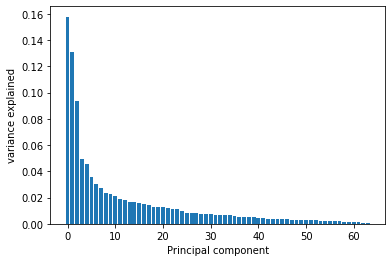

In [109]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal component")
plt.ylabel("variance explained")
plt.show()


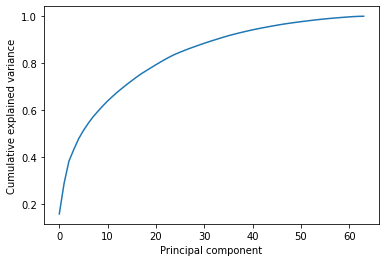

In [128]:
#For Cumulative variance
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal component")
plt.ylabel("Cumulative explained variance")
plt.show()


In [130]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_new = PCA(n_components=30)
azdias_pca = pca_new.fit_transform(azdias_new_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I will choose 30 Principal Components as they have cumulative variance of more than 0.8 i.e 80% as well as choosing 30 components will also reduce alot of complexity of data to work upon. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [131]:
def pca_weight(n,pca):
    df = pd.DataFrame(pca.components_)
    df.columns=list(azdias_new_scaled.columns)
    weight= df.iloc[n].sort_values()
    
    return weight

FINANZ_MINIMALIST                -0.229228
KBA05_ANTG1                      -0.216447
MOBI_REGIO                       -0.213496
PLZ8_ANTG1                       -0.209702
KBA05_GBZ                        -0.183925
KONSUMNAEHE                      -0.168578
INNENSTADT                       -0.166077
PLZ8_GBZ                         -0.147711
ALTERSKATEGORIE_GROB             -0.140568
FINANZ_VORSORGER                 -0.132591
BALLRAUM                         -0.129268
CAMEO_INTL_2015_LIFE             -0.126660
GEBAEUDETYP_RASTER               -0.117956
GREEN_AVANTGARDE                 -0.109371
SEMIO_ERL                        -0.092856
SEMIO_LUST                       -0.088651
KBA13_ANZAHL_PKW                 -0.076925
ANZ_PERSONEN                     -0.076050
WOHNDAUER_2008                   -0.066109
OST_WEST_KZ                      -0.053966
MIN_GEBAEUDEJAHR                 -0.041470
SEMIO_VERT                       -0.037308
ONLINE_AFFINITAET                -0.032043
RETOURTYP_B

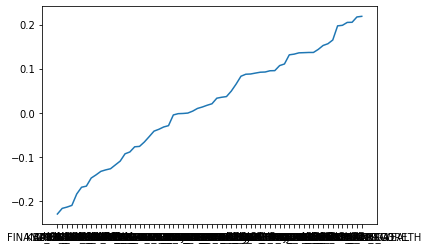

In [164]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pd.options.display.max_rows = 80

print(pca_weight(0,pca_new))
plt.plot(pca_weight(0,pca_new))


SEMIO_REL                        -0.248412
SEMIO_TRADV                      -0.225638
PRAEGENDE_JUGENDJAHRE_decade     -0.225370
SEMIO_KULT                       -0.223489
FINANZ_SPARER                    -0.219638
FINANZ_UNAUFFAELLIGER            -0.217157
SEMIO_PFLICHT                    -0.215152
FINANZ_ANLEGER                   -0.192104
SEMIO_FAM                        -0.188313
ONLINE_AFFINITAET                -0.165918
SEMIO_MAT                        -0.160775
SEMIO_RAT                        -0.156609
SEMIO_SOZ                        -0.110195
PLZ8_ANTG1                       -0.093593
INNENSTADT                       -0.087971
SEMIO_VERT                       -0.087529
KBA05_ANTG1                      -0.084763
KONSUMNAEHE                      -0.083292
MOBI_REGIO                       -0.082822
KBA05_GBZ                        -0.076368
BALLRAUM                         -0.071612
PLZ8_GBZ                         -0.065944
ANZ_PERSONEN                     -0.064263
MIN_GEBAEUD

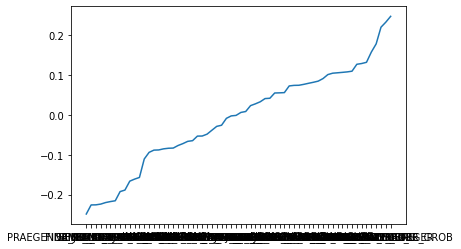

In [165]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weight(1,pca_new))
plt.plot(pca_weight(1,pca_new))

ANREDE_KZ                        -0.366459
SEMIO_KAEM                       -0.332063
SEMIO_DOM                        -0.311098
SEMIO_KRIT                       -0.269785
SEMIO_RAT                        -0.228467
FINANZ_ANLEGER                   -0.198255
SEMIO_ERL                        -0.165373
FINANZ_SPARER                    -0.116181
FINANZ_UNAUFFAELLIGER            -0.110596
PRAEGENDE_JUGENDJAHRE_decade     -0.095000
SEMIO_TRADV                      -0.092936
SEMIO_PFLICHT                    -0.089727
ONLINE_AFFINITAET                -0.062907
INNENSTADT                       -0.048205
PLZ8_ANTG1                       -0.047165
KONSUMNAEHE                      -0.042706
BALLRAUM                         -0.039113
PLZ8_GBZ                         -0.036302
FINANZ_HAUSBAUER                 -0.035673
PRAEGENDE_JUGENDJAHRE_movement   -0.033594
GEBAEUDETYP_RASTER               -0.033396
MOBI_REGIO                       -0.027244
KBA05_ANTG1                      -0.025869
KBA13_ANZAH

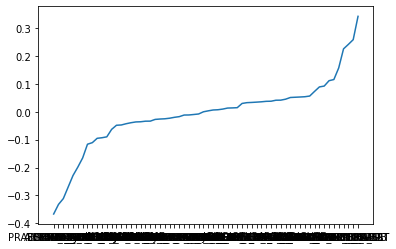

In [166]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weight(2,pca_new))
plt.plot(pca_weight(2,pca_new))

### Discussion 2.3: Interpret Principal Components


Lets pick some principal components of both positive as well as negative values. Then we will describe their meanings from given Dictionary Data. At last we will do some conclusions:

1. First Principal Component:
 - Positives: PLZ8_ANTG3 (Number of 6-10 family houses), PLZ8_ANTG4(Number of 10+ family houses), CAMEO_INTL_2015_WEALTH (Wealth w.r.t hoouseholds)   
 - Negatives:FINANZ_MINIMALIST(low financial interest), KBA05_ANTG1(Number of 1-2 family houses in the microcell)  MOBI_REGIO(Movement patterns)
  
2. Second Principal Component:
 - Positives: ALTERSKATEGORIE_GROB(Estimated age), SEMIO_ERL(Personality-event-oriented)
 - Negatives: SEMIO_REL(Personality-religious), SEMIO_TRADV(Personality-tradional-minded)

3. Third Principal Component:
 - Positives: SEMIO_VERT(Personality-dreamful), SEMIO_SOZ(Personality-socially-minded)    
 - Negatives: ANREDE_KZ(Gender), SEMIO_KAEM(Personality-combative attitude) 
 
 Conclusion: Definitely we can observe some patterns according to which positive-positive, negative-negative and positive-negatives have some relations. 
 
 Ex 1: PLZ8_ANTG3 (Number of 6-10 family houses) and PLZ8_ANTG4(Number of 10+ family houses) both are most positive of first principal component and will grow together as they together define somewhat same range of family houses.
 
 Ex 2: SEMIO_REL(Personality-religious) and SEMIO_TRADV(Personality-tradional-minded) both are most negative of second principal component and are also related as generally we observe traditional people are more indulged in religious practice.
  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [169]:
# Loop over a number of different cluster counts...
#scores = []
#clusters = list(range(3,15,2))
#for n in clusters:
#    kmeans = KMeans(n)
#    model = kmeans.fit(azdias_pca)
#    
#    score = np.abs(model.score(azdias_pca))
#    scores.append(score)
 
    

Text(0, 0.5, 'SSE')

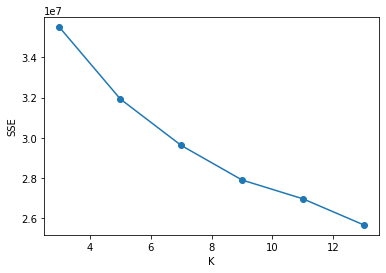

In [171]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#plt.plot(clusters, scores, marker='o')
#plt.xlabel('K')
#plt.ylabel('SSE')

#Left for reference as the range should be increased more

In [172]:
#Range of clusters is increased to 25 to get more cluster point to find the right elbow point
scores = []
clusters = list(range(3,25,2))
for n in clusters:
    kmeans = KMeans(n)
    model = kmeans.fit(azdias_pca)
    
    score = np.abs(model.score(azdias_pca))
    scores.append(score)

Text(0, 0.5, 'Score')

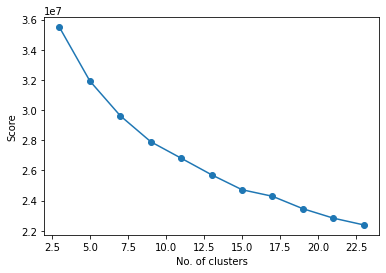

In [173]:
plt.plot(clusters, scores, marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Score')

In [174]:
# Re-fit the k-means model with the selected number of clusters and obtain
kmeans_new = KMeans(15)
model_new = kmeans_new.fit(azdias_pca)

# cluster predictions for the general population demographics data.
pred = model_new.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

According to me 15 is the right elbow point as the score was decreasing significantly with no. of clusters increasing till 15th cluster only.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [175]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [177]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_updated = clean_data(customers,feat_info)

In [178]:
customers_updated.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [180]:
customers_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 0 to 191651
Data columns (total 64 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            141359 non-null  float64
 1   ANREDE_KZ                       141590 non-null  float64
 2   FINANZ_MINIMALIST               141590 non-null  float64
 3   FINANZ_SPARER                   141590 non-null  float64
 4   FINANZ_VORSORGER                141590 non-null  float64
 5   FINANZ_ANLEGER                  141590 non-null  float64
 6   FINANZ_UNAUFFAELLIGER           141590 non-null  float64
 7   FINANZ_HAUSBAUER                141590 non-null  float64
 8   GREEN_AVANTGARDE                141590 non-null  int64  
 9   HEALTH_TYP                      139282 non-null  float64
 10  RETOURTYP_BK_S                  138491 non-null  float64
 11  SEMIO_SOZ                       141590 non-null  float64
 12  SEMIO_FAM       

In [185]:
#Lets check for null values in the customers_updated data
customers_updated.isnull().sum().sum()

102081

In [186]:
#Replacing NaNs with 0
customers_updated.fillna(0,inplace=True)

In [187]:
customers_updated.isnull().sum().sum()

0

In [191]:
#Now lets scale the customers_updated data
Fscaler=scaler.transform(customers_updated)
customers_new_scaled=pd.DataFrame(Fscaler,columns=list(customers_updated.columns))
customers_new_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,0.698018,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,-0.553522,1.006178,-1.154864,...,-0.833723,1.366121,1.297642,-1.771351,-1.422986,-1.319305,-0.630241,-0.988344,-1.124660,-0.269440
1,0.698018,1.42288,0.723000,-0.516937,0.516188,-0.600675,2.183668,0.965412,1.006178,0.086225,...,0.740465,-0.538496,-1.392684,0.183288,-0.045784,0.079750,-0.630241,-0.988344,0.291939,0.468058
2,0.698018,-0.70280,0.723000,-0.516937,0.516188,0.397173,-0.884400,-0.553522,-0.993860,0.086225,...,-0.833723,-0.538496,0.400867,-1.771351,-0.963919,-1.319305,-1.361364,1.011794,-0.416360,0.468058
3,-0.648692,-0.70280,-1.242075,-0.516937,-0.665858,2.392870,3.206358,-0.553522,-0.993860,1.327314,...,0.740465,-0.538496,-0.495909,0.183288,-0.045784,-1.319305,0.832006,1.011794,1.000238,-1.744436
4,-0.648692,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,0.205945,1.006178,1.327314,...,0.740465,1.366121,1.297642,0.183288,0.872352,1.478805,-0.630241,-0.988344,0.291939,0.468058


In [194]:
#Applying PCA from pca_new model with 30 principal components
customers_pca=pca_new.transform(customers_new_scaled)

In [195]:
#Prediction from kmeans_new model with 15 clusters
customers_pred=kmeans_new.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'General Population')

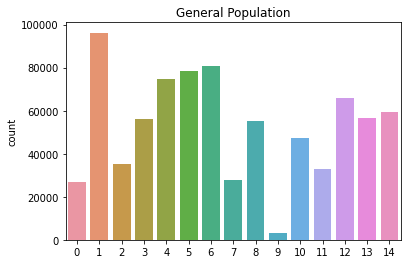

In [225]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(pred).set_title("General Population")

Text(0.5, 1.0, 'Customers')

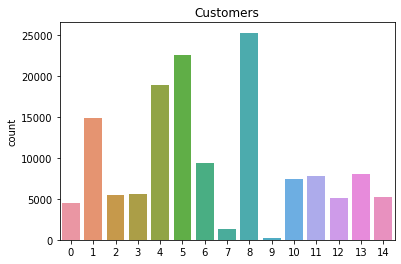

In [226]:
sns.countplot(customers_pred).set_title("Customers")


In [232]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
invtf = scaler.inverse_transform(pca_new.inverse_transform(kmeans_new.cluster_centers_[8]))
overrepresented = pd.Series(data = invtf, index = customers_updated.columns)
overrepresented

ALTERSKATEGORIE_GROB                 3.875803
ANREDE_KZ                            0.887366
FINANZ_MINIMALIST                    5.585040
FINANZ_SPARER                        0.802524
FINANZ_VORSORGER                     5.048857
FINANZ_ANLEGER                       0.682124
FINANZ_UNAUFFAELLIGER                1.517971
FINANZ_HAUSBAUER                     1.638642
GREEN_AVANTGARDE                     1.409229
HEALTH_TYP                           1.925244
RETOURTYP_BK_S                       4.278620
SEMIO_SOZ                            4.968331
SEMIO_FAM                            4.500090
SEMIO_REL                            2.969837
SEMIO_MAT                            3.491064
SEMIO_VERT                           6.959912
SEMIO_LUST                           6.259028
SEMIO_ERL                            4.383131
SEMIO_KULT                           4.582457
SEMIO_RAT                            1.853461
SEMIO_KRIT                           2.447667
SEMIO_DOM                         

In [230]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster index 9 has least counts but in comparision to general population cluster index 12 is underrepresented
invtf2 = scaler.inverse_transform(pca_new.inverse_transform(kmeans_new.cluster_centers_[12]))
underrepresented = pd.Series(data = invtf2, index = customers_updated.columns)
underrepresented


ALTERSKATEGORIE_GROB                 2.547262
ANREDE_KZ                            1.796131
FINANZ_MINIMALIST                    2.878481
FINANZ_SPARER                        2.287184
FINANZ_VORSORGER                     3.796625
FINANZ_ANLEGER                       2.437562
FINANZ_UNAUFFAELLIGER                2.547494
FINANZ_HAUSBAUER                     3.723716
GREEN_AVANTGARDE                     0.269773
HEALTH_TYP                           2.016503
RETOURTYP_BK_S                       2.902201
SEMIO_SOZ                            3.565863
SEMIO_FAM                            3.744225
SEMIO_REL                            4.266676
SEMIO_MAT                            4.781001
SEMIO_VERT                           3.287669
SEMIO_LUST                           4.137161
SEMIO_ERL                            4.406397
SEMIO_KULT                           3.978894
SEMIO_RAT                            5.028678
SEMIO_KRIT                           4.958580
SEMIO_DOM                         

In [239]:
compare=pd.DataFrame({"underrepresented":underrepresented,"overrepresented":overrepresented})

compare


,underrepresented,overrepresented
ALTERSKATEGORIE_GROB,2.547262,3.875803
ANREDE_KZ,1.796131,0.887366
ANZ_HAUSHALTE_AKTIV,10.736082,-0.943125
ANZ_HH_TITEL,0.081782,0.009037
ANZ_PERSONEN,1.979234,2.863053
ANZ_TITEL,0.011361,0.011272
ARBEIT,3.370818,2.667371
BALLRAUM,3.204765,4.224377
CAMEO_INTL_2015_LIFE,2.631341,4.039943
CAMEO_INTL_2015_WEALTH,3.663266,1.472913


### Discussion 3.3: Compare Customer Data to Demographics Data

 - Some popular features from overrepresented segments incomparision to customer data (cluster index 8) are:
1. SEMIO_VERT(Personality-dreamful)i.e 6.9
2. SEMIO_SOZ(Personality-Social Minded)i.e 4.9
3. SEMIO_LUST(Personality-sensual-minded)i.e 6.2
4. WOHNDAUER_2008(Length of residence)i.e 8.9
 - This group maybe benificial for company.
 
 
 - Some popular features from underrepresented segments incomparision to customer data(cluster index 12) are:
1. SEMIO_DOM(Personality-dominant-minded)i.e 5.5
2. SEMIO_KAEM(Personality-combative-attitude)i.e 5.4
3. SEMIO_KRIT(Personality-critical-minded)i.e 4.9
3. PLZ8_ANTG3(Number of 6-10 family houses)i.e 2.1
 - This group is not benificial for company

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.